# 12 权重衰退

### 增加罚项

$$ loss = L(w,b) + \frac{\lambda}{2}||w||^2 $$

其中 $l(w,b)$ 是损失函数，$||w||^2$ 是权重的 L2 范数。

#### 梯度下降更新

$$ w_{t+1} = \frac{\partial loss}{\partial w_t} = (1 - \eta\lambda) w_t - \eta \frac{\partial L}{\partial w_t} $$

### 代码实现 —— 线性回归

1. 加载数据

In [48]:
import torch
from torch.utils import data
from d2l import torch as d2l
from torch import nn

def synthetic_data(w,b,num_examples):
    X = torch.normal(0,1,size=(num_examples,len(w)))
    y = torch.matmul(X,w) + b + torch.normal(0,0.01,size=(num_examples,1))
    return (X,y)

def load_array(train_data,batch_size,is_train=True):
    dataset = data.TensorDataset(*train_data)
    data_loader = data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return data_loader

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)
 
for X, y in train_iter:
    print(X.shape, y.shape)


torch.Size([5, 200]) torch.Size([5, 1])
torch.Size([5, 200]) torch.Size([5, 1])
torch.Size([5, 200]) torch.Size([5, 1])
torch.Size([5, 200]) torch.Size([5, 1])


2. 定义模型、损失函数和优化器；定义训练模型的函数

In [49]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

w, b = init_params()

def net(X):
    return torch.matmul(X, w) + b

optimizer = torch.optim.SGD([w, b], lr=0.01, weight_decay=0.01)

def train(lambd):
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            # optimizer.zero_grad()
            l.sum().backward()
            # optimizer.step()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 14.633475303649902


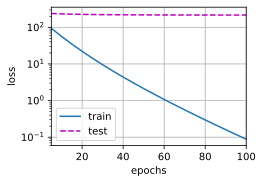

In [43]:
w, b = init_params()
train(lambd=0)

w的L2范数是： 0.3387041687965393


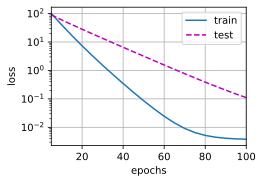

In [44]:
w, b = init_params()
train(lambd=15)

### 简洁实现

w的L2范数： 13.703784942626953


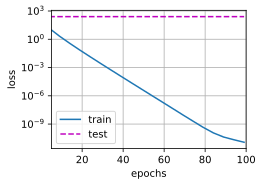

In [50]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs = 100
    lr = 0.003
    trainer = torch.optim.SGD([{'params':net[0].weight,'weight_decay':wd},
                               {'params':net[0].bias}],lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward() # 这里由于上面定义reduction='none'，所以需要对l求均值再反向传播
            trainer.step()
        
        if (epoch+1)%5==0:
            animator.add(epoch,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
    
    print('w的L2范数：', net[0].weight.norm().item())

train_concise(0)

w的L2范数： 1.1568080186843872


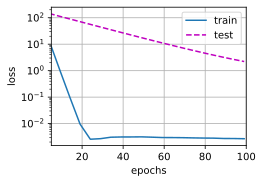

In [51]:
train_concise(2)

w的L2范数： 0.03561762720346451


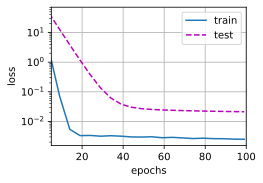

In [52]:
train_concise(10)